In [1]:
# 安裝 finrl 套件
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package swig4.0.
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ...
Unpacking swig (4.0.2-1ubuntu1) ...
Setting up libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Setting up swig4.0 (4.0.2-1ubuntu1) ...
Setting up swig (4.0.2-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-xjdb5u2w
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-xjdb5u2w
  Resolved https://github

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# requirement
# Yahoo Finance API
# pandas
# numpy
# matplotlib
# stockstats
# OpenAI gym
# stable-baselines
# tensorflow
# pyfolio
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
# from finrl.config_tickers import SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [4]:
#建立資料夾
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#從2022年選擇權重最高的20檔股票
SP_500_TOP20_TICKER = ['AAPL','MSFT','AMZN','NVDA','GOOGL','META','GOOG','TSLA','BRK','AVGO','JPM','UNH','LLY','V','XOM','JNJ','MA','HD','PG','COST']
#從2022年選擇ESG分數最高的20檔股票
# SP_500_ESGTOP20_TICKER = ["CL","CVS","MMM","MET","MSFT","CLX","TGT","NEM","CTRA","INCY","PEP","SLB","HAL","COP","HSY","C","BEN","GS","PPL","FMC"]

In [6]:
#資料區間為2013至2022
#2013至2019為訓練資料
#2020至2022為測試資料
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2022-12-31'
#運用YahooDownloader下載資料
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = SP_500_TOP20_TICKER).fetch_data()
#將資料存成datasets_noESG.csv
df.to_csv('datasets_noESG_TOP20.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
#檢視前5筆資料
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2013-01-02,19.779285,19.821428,19.343929,16.769094,560518000,AAPL,2
1,2013-01-02,12.804000,12.905000,12.663000,12.865500,65420000,AMZN,2
2,2013-01-02,32.430000,33.060001,32.240002,24.214560,3671600,AVGO,2
3,2013-01-02,0.113900,0.113900,0.113900,0.113900,0,BRK,2
4,2013-01-02,100.599998,101.449997,100.209999,80.878326,3153800,COST,2


In [8]:
#檢視最後5筆資料
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
49454,2022-12-30,152.429993,152.679993,150.440002,147.807709,4532000,PG,4
49455,2022-12-30,119.949997,124.480003,119.750000,123.180000,157777300,TSLA,4
49456,2022-12-30,530.000000,530.500000,524.840027,522.316406,1849600,UNH,4
49457,2022-12-30,206.309998,208.039993,205.699997,206.123154,4159400,V,4
49458,2022-12-30,108.610001,110.500000,108.610001,106.658455,11799600,XOM,4


In [9]:
#檢視資料維度
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(49459, 8)

In [10]:
#針對資料進行排序並檢視
df.sort_values(['tic','date']).head()

,date,open,high,low,close,volume,tic,day
0,2013-01-02,19.779285,19.821428,19.343929,16.769094,560518000,AAPL,2
20,2013-01-03,19.567142,19.631071,19.321428,16.557434,352965200,AAPL,3
40,2013-01-04,19.177500,19.236786,18.779642,16.096231,594333600,AAPL,4
60,2013-01-07,18.642857,18.903570,18.400000,16.001545,484156400,AAPL,0
80,2013-01-08,18.900356,18.996071,18.616072,16.044611,458707200,AAPL,1


In [11]:
#檢視股票個數
len(df.tic.unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20

In [12]:
#檢視各股票資料量
df.tic.value_counts()

AAPL     2518
AMZN     2518
V        2518
UNH      2518
TSLA     2518
PG       2518
NVDA     2518
MSFT     2518
META     2518
MA       2518
LLY      2518
JPM      2518
JNJ      2518
HD       2518
GOOGL    2518
GOOG     2518
COST     2518
AVGO     2518
XOM      2518
BRK      1617
Name: tic, dtype: int64

In [13]:
 #技術指標List
 INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30',
                 'close_30_sma', 'close_60_sma']  # 'boll_up', 'boll_dn',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#進行特徵工程
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
#填補空值
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [15]:
#檢視其中5筆資料
processed.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
29545,2019-03-08,42.580002,43.267502,42.375000,41.668163,95997600,AAPL,4,0.612320,51.887150,29.548960,6.268041,40.986680,39.224849,39.704292
9907,2015-01-28,56.619999,56.680000,54.750000,42.798782,24354400,JPM,2,-0.999459,39.731161,-117.597477,38.975331,46.225221,46.768159,52.946121
46508,2022-09-21,308.290009,313.799988,300.630005,300.799988,62555700,TSLA,2,5.698226,54.562288,82.243974,13.094903,294.182557,276.913612,8.106633
40828,2021-07-15,411.910004,421.730011,407.200012,405.834351,3546500,UNH,3,4.280169,61.725560,144.903423,24.252697,389.912979,391.057716,23.803028
15317,2016-03-16,153.699997,155.000000,152.630005,131.425690,1485500,COST,2,0.669779,52.293544,122.200170,3.510071,127.986889,129.956275,8.667785


In [16]:
#計算股票個數及狀態空間
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 19, State Space: 153


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#設定環境參數
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [18]:
rebalance_window = 63 # rebalance_window 是重訓練模型的天數
validation_window = 63 # validation_window 是執行驗證與交易的天數
#DRLEnsembleAgent是將多個強化學習agent的策略進行整合，並透過一定的規則或方法綜合它們的輸出，以得到更好的交易策略
ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [19]:
#設定A2C、PPO、DDPG的模型參數
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [20]:
#執行ensemble strategy，結果為df_summary
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  156.32112866751586
======Model training from:  2013-01-01 to  2020-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 148       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -27       |
|    explained_variance | -0.142    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 104       |
|    reward             | 0.6112692 |
|    std                | 1         |
|    value_loss         | 17.4      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 15

In [21]:
#顯示df_summary
df_summary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-01-02,2020-04-02,A2C,-0.146673,-0.192007,-0.211961
1,189,2020-04-02,2020-07-02,A2C,0.423133,0.344667,0.354023
2,252,2020-07-02,2020-10-01,DDPG,0.044539,0.136988,0.1627
3,315,2020-10-01,2020-12-31,PPO,0.229332,0.343477,0.141107
4,378,2020-12-31,2021-04-05,A2C,0.299618,0.038105,0.146189
5,441,2021-04-05,2021-07-02,A2C,0.27031,0.209697,0.221702
6,504,2021-07-02,2021-10-01,PPO,-0.097916,-0.040484,-0.086422
7,567,2021-10-01,2021-12-31,DDPG,0.411554,0.444056,0.525012
8,630,2021-12-31,2022-04-01,A2C,-0.073768,-0.102403,-0.092662
9,693,2022-04-01,2022-07-05,PPO,-0.243581,-0.176471,-0.232777


In [22]:
#交易日期
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
unique_trade_date

array(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
       '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
       '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
       '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-10', '2020-02-11',
       '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-18',
       '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-24',
       '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
       '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-09', '2020-03-10', '2020-03-11',
       '2020-03-12', '2020-03-13', '2020-03-16', '2020-03-17',
       '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-23',
       '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-

In [24]:
#回測交易策略
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
print(df_trade_date)
print(rebalance_window)
print(validation_window)
print(len(unique_trade_date)+1)
df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

       datadate
0    2020-01-02
1    2020-01-03
2    2020-01-06
3    2020-01-07
4    2020-01-08
..          ...
751  2022-12-23
752  2022-12-27
753  2022-12-28
754  2022-12-29
755  2022-12-30

[756 rows x 1 columns]
63
63
757
Sharpe Ratio:  0.9882839118994234


In [25]:
df_account_value.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,account_value,date,daily_return,datadate
0,1.000000e+06,2020-04-02,NaN,2020-04-02
1,9.979681e+05,2020-04-03,-0.002032,2020-04-03
2,1.011997e+06,2020-04-06,0.014058,2020-04-06
3,1.009911e+06,2020-04-07,-0.002062,2020-04-07
4,1.021705e+06,2020-04-08,0.011678,2020-04-08


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

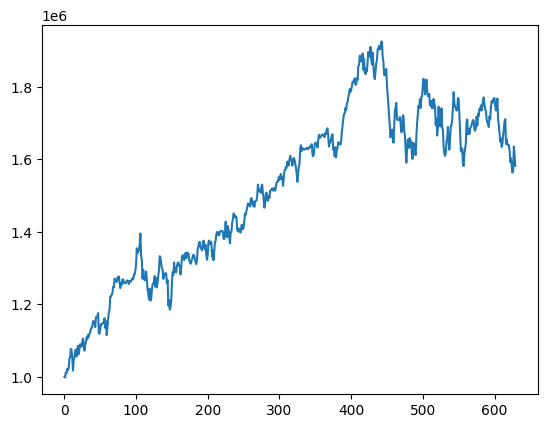

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

In [27]:
df_a2c_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('A2C',i))
    df_a2c_value = df_a2c_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_a2c_value.account_value.pct_change(1).mean()/df_a2c_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_a2c_value=df_a2c_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.09596658262898233


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

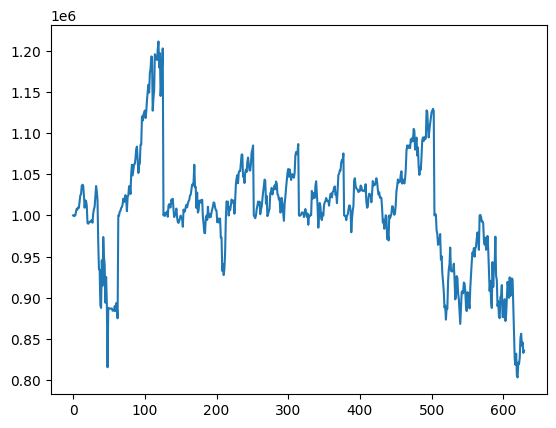

In [28]:
%matplotlib inline
df_a2c_value.account_value.plot()

In [29]:
df_ppo_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('PPO',i))
    df_ppo_value = df_ppo_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_a2c_value.account_value.pct_change(1).mean()/df_a2c_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_ppo_value=df_ppo_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.09596658262898233


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

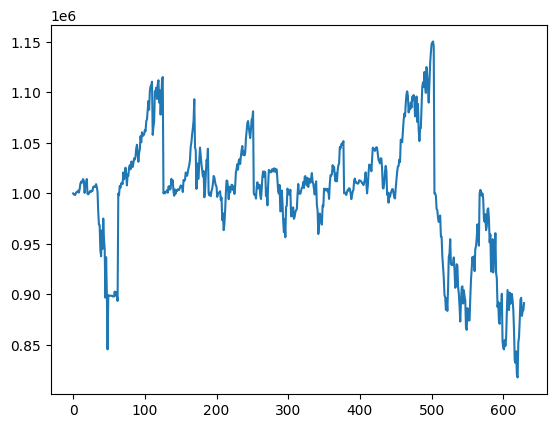

In [30]:
%matplotlib inline
df_ppo_value.account_value.plot()

In [31]:
df_ddpg_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('DDPG',i))
    df_ddpg_value = df_ddpg_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_ddpg_value.account_value.pct_change(1).mean()/df_ddpg_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_ddpg_value=df_ddpg_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.01666515277896306


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

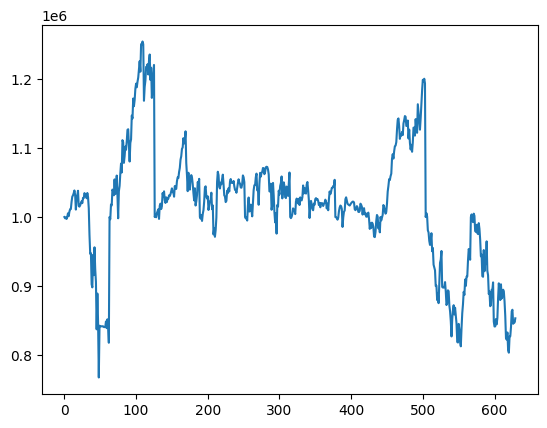

In [32]:
%matplotlib inline
df_ddpg_value.account_value.plot()

In [33]:
#BackTestStats
print("==============Get Backtest Results===========")
print("======================Ensemble=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================Ensemble=======================
Annual return          0.201473
Cumulative returns     0.582286
Annual volatility      0.208008
Sharpe ratio           0.988284
Calmar ratio           1.072525
Stability              0.807948
Max drawdown          -0.187849
Omega ratio            1.179540
Sortino ratio          1.389699
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.950127
Daily value at risk   -0.025391
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
print("==============Get Backtest Results===========")
print("======================A2C=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_a2c_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================A2C=======================
Annual return         -0.069210
Cumulative returns    -0.164147
Annual volatility      0.293133
Sharpe ratio          -0.095967
Calmar ratio          -0.205504
Stability              0.126691
Max drawdown          -0.336780
Omega ratio            0.979127
Sortino ratio         -0.124530
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.806636
Daily value at risk   -0.037043
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
print("==============Get Backtest Results===========")
print("======================PPO=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_ppo_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================PPO=======================
Annual return         -0.044936
Cumulative returns    -0.108583
Annual volatility      0.242257
Sharpe ratio          -0.067525
Calmar ratio          -0.155451
Stability              0.119402
Max drawdown          -0.289070
Omega ratio            0.985645
Sortino ratio         -0.087911
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.853049
Daily value at risk   -0.030586
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
print("==============Get Backtest Results===========")
print("======================DDPG=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_ddpg_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================DDPG=======================
Annual return         -0.061378
Cumulative returns    -0.146454
Annual volatility      0.338851
Sharpe ratio          -0.016665
Calmar ratio          -0.171021
Stability              0.145014
Max drawdown          -0.358892
Omega ratio            0.996334
Sortino ratio         -0.022629
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.864182
Daily value at risk   -0.042714
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
#baseline stats
print("==============Get Baseline Stats===========")
df_sp500_ = get_baseline(
        ticker="^GSPC",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_sp500_, value_col_name = 'close')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (629, 8)
Annual return          0.157520
Cumulative returns     0.440686
Annual volatility      0.197045
Sharpe ratio           0.842326
Calmar ratio           0.653544
Stability              0.542290
Max drawdown          -0.241025
Omega ratio            1.155100
Sortino ratio          1.189602
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.934728
Daily value at risk   -0.024167
dtype: float64


In [38]:
df_sp500 = pd.DataFrame()
df_sp500['date'] = df_account_value['date']
df_sp500['sp500'] = df_sp500_['close'] / df_sp500_['close'][0] * env_kwargs["initial_amount"]
print("df_sp500: ", df_sp500)
df_sp500.to_csv("df_sp500.csv")
df_sp500 = df_sp500.set_index(df_sp500.columns[0])
print("df_sp500: ", df_sp500)
df_sp500.to_csv("df_sp500+.csv")

df_account_value.to_csv('df_account_value.csv')


df_sp500:             date         sp500
0    2020-04-02  1.000000e+06
1    2020-04-03  9.848629e+05
2    2020-04-06  1.054130e+06
3    2020-04-07  1.052440e+06
4    2020-04-08  1.088282e+06
..          ...           ...
625  2022-09-26  1.446452e+06
626  2022-09-27  1.443385e+06
627  2022-09-28  1.471780e+06
628  2022-09-29  1.440686e+06
629  2022-09-30           NaN

[630 rows x 2 columns]
df_sp500:                     sp500
date                    
2020-04-02  1.000000e+06
2020-04-03  9.848629e+05
2020-04-06  1.054130e+06
2020-04-07  1.052440e+06
2020-04-08  1.088282e+06
...                  ...
2022-09-26  1.446452e+06
2022-09-27  1.443385e+06
2022-09-28  1.471780e+06
2022-09-29  1.440686e+06
2022-09-30           NaN

[630 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_result_a2c.columns:  Index(['a2c'], dtype='object')
df_result_ppo.columns:  Index(['ppo'], dtype='object')
df_result_ddpg.columns:  Index(['ddpg'], dtype='object')
df_trade_date:         datadate
0    2020-01-02
1    2020-01-03
2    2020-01-06
3    2020-01-07
4    2020-01-08
..          ...
751  2022-12-23
752  2022-12-27
753  2022-12-28
754  2022-12-29
755  2022-12-30

[756 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2020-04-02  1.000000e+06
2020-04-03  9.979681e+05
2020-04-06  1.011997e+06
2020-04-07  1.009911e+06
2020-04-08  1.021705e+06
...                  ...
2022-09-26  1.563712e+06
2022-09-27  1.573036e+06
2022-09-28  1.635639e+06
2022-09-29  1.607405e+06
2022-09-30  1.582286e+06

[630 rows x 1 columns]
df_result_a2c:                       a2c
date                    
2020-01-02  1.000000e+06
2020-01-03  9.992376e+05
2020-01-06  1.000255e+06
2020-01-07  9.999098e+05


<Figure size 2000x1000 with 0 Axes>

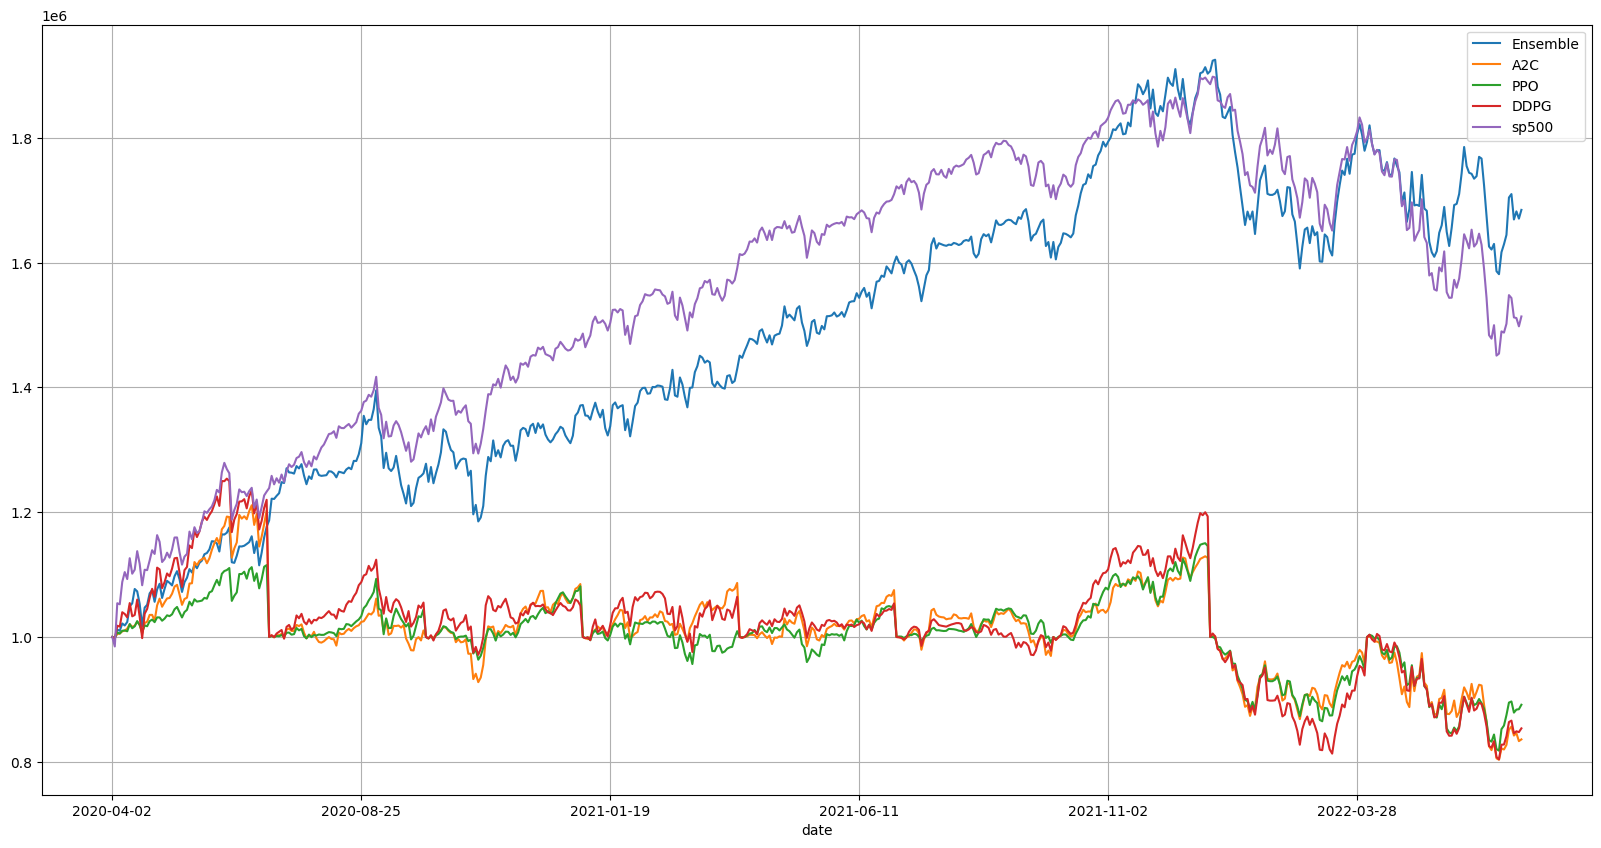

In [39]:
# BackTestPlot
# print("==============Compare to sp500===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^GSPC',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

df_result_a2c = pd.DataFrame({'date': df_a2c_value['date'], 'a2c': df_a2c_value['account_value']})
df_result_a2c = df_result_a2c.set_index('date')

df_result_ppo = pd.DataFrame({'date': df_ppo_value['date'], 'ppo': df_ppo_value['account_value']})
df_result_ppo = df_result_ppo.set_index('date')

df_result_ddpg = pd.DataFrame({'date': df_ddpg_value['date'], 'ddpg': df_ddpg_value['account_value']})
df_result_ddpg = df_result_ddpg.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)
print("df_result_a2c.columns: ", df_result_a2c.columns)
print("df_result_ppo.columns: ", df_result_ppo.columns)
print("df_result_ddpg.columns: ", df_result_ddpg.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
df_result_a2c.to_csv("df_result_a2c.csv")
df_result_ppo.to_csv("df_result_ppo.csv")
df_result_ddpg.to_csv("df_result_ddpg.csv")

print("df_result_ensemble: ", df_result_ensemble)
print("df_result_a2c: ", df_result_a2c)
print("df_result_ppo: ", df_result_ppo)
print("df_result_ddpg: ", df_result_ddpg)
print("==============Compare to GSPCA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_sp500, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_result_a2c, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_sp500, left_index=True, right_index=True)

print("result: ", result)
result.to_csv("result.csv")
result.columns = ['Ensemble','A2C','PPO','DDPG', 'sp500']

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.figure();

ax = result.plot()
ax.grid(True)

plt.show()

In [40]:
# EXTRACT TURBULENCE INDEX
turbulence_df = processed.groupby(['date'])['turbulence'].last().reset_index()
selected_df = turbulence_df[(turbulence_df['date'] >= '2020-04-02') & (turbulence_df['date'] <= '2020-05-01')]
selected_df = selected_df.set_index('date')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


df_result_ensemble:                  ensemble
date                    
2020-04-02  1.000000e+06
2020-04-03  9.979681e+05
2020-04-06  1.011997e+06
2020-04-07  1.009911e+06
2020-04-08  1.021705e+06
...                  ...
2022-09-26  1.563712e+06
2022-09-27  1.573036e+06
2022-09-28  1.635639e+06
2022-09-29  1.607405e+06
2022-09-30  1.582286e+06

[630 rows x 1 columns]
df_result_a2c:                       a2c
date                    
2020-01-02  1.000000e+06
2020-01-03  9.992376e+05
2020-01-06  1.000255e+06
2020-01-07  9.999098e+05
2020-01-08  1.004684e+06
...                  ...
2022-06-27  8.563695e+05
2022-06-28  8.420589e+05
2022-06-29  8.458246e+05
2022-06-30  8.331037e+05
2022-07-01  8.358527e+05

[630 rows x 1 columns]
df_result_ppo:                       ppo
date                    
2020-01-02  1.000000e+06
2020-01-03  9.988533e+05
2020-01-06  9.993644e+05
2020-01-07  9.984953e+05
2020-01-08  1.000614e+06
...                  ...
2022-06-27  8.966749e+05
2022-06-28  8.788081e+05

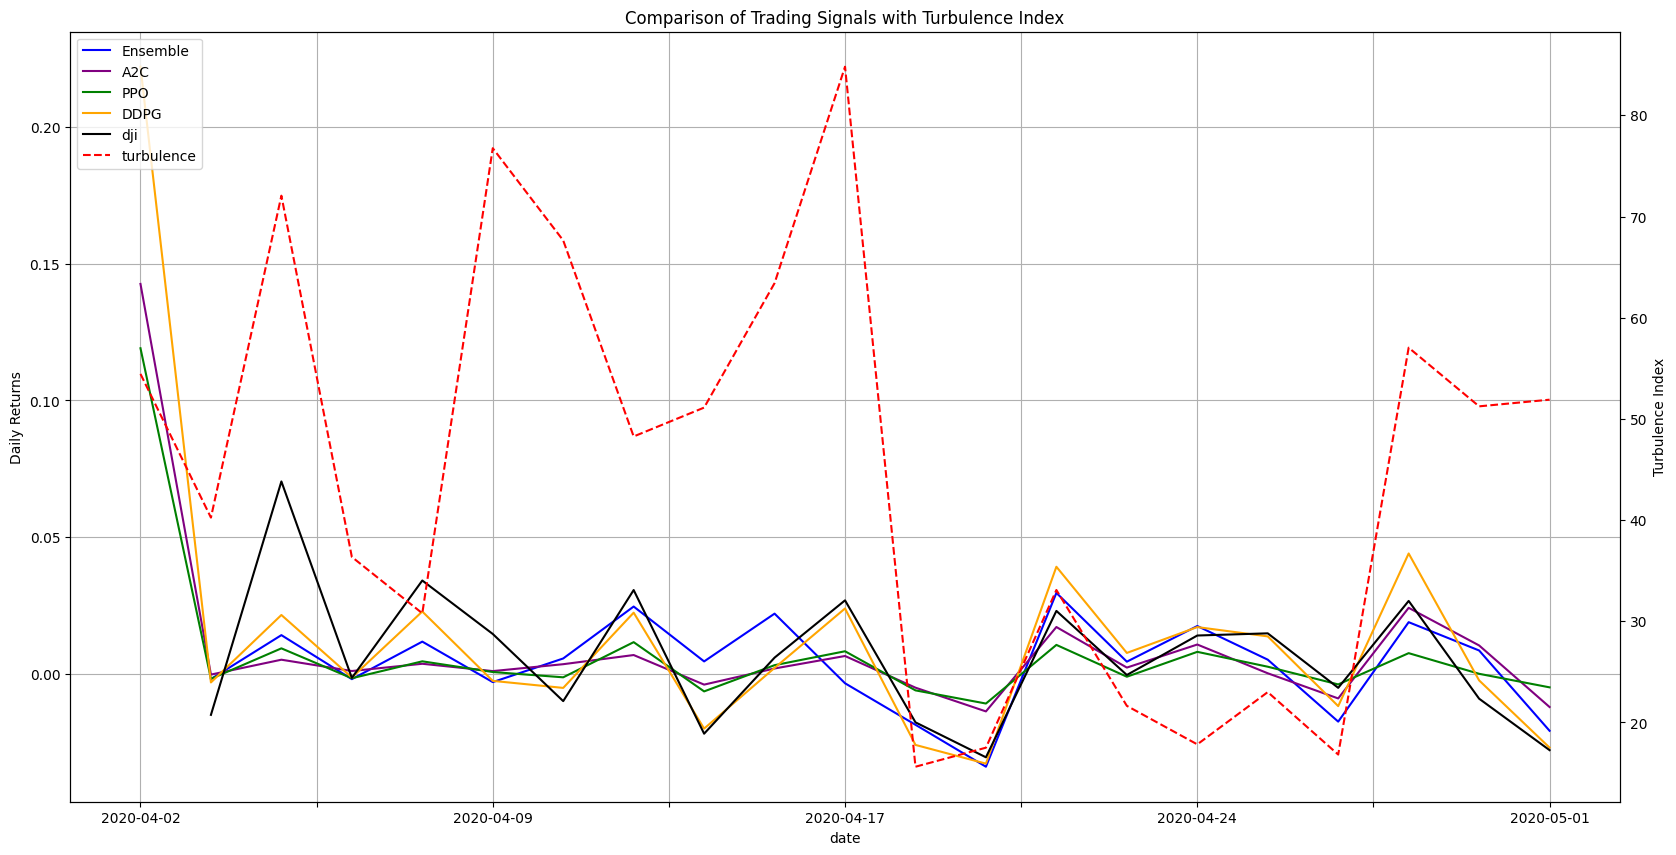

In [41]:
###############################DAILY RETURNS#######################################
print("df_result_ensemble: ", df_result_ensemble)
print("df_result_a2c: ", df_result_a2c)
print("df_result_ppo: ", df_result_ppo)
print("df_result_ddpg: ", df_result_ddpg)
print("==============Compare to S&P500===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble.pct_change(1), df_result_a2c.pct_change(1), left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo.pct_change(1), left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg.pct_change(1), left_index=True, right_index=True)
result = pd.merge(result, df_sp500.pct_change(1), left_index=True, right_index=True)

# results during market crash 2-01-2020 to 7-05-2020

print("result: ", result)

result.columns = ['Ensemble','A2C','PPO','DDPG', 'dji']

import matplotlib.pyplot as plt
result = result.loc['2020-04-02':'2020-05-01']

# create a figure with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot the daily returns of each signal on the left y-axis
result['Ensemble'].plot(ax=ax1, color='blue')
result['A2C'].plot(ax=ax1, color='purple')
result['PPO'].plot(ax=ax1, color='green')
result['DDPG'].plot(ax=ax1, color='orange')
result['dji'].plot(ax=ax1, color='black')
selected_df['turbulence'].plot(ax=ax2, color='red', linestyle='--')


# set the y-axis labels and title
ax1.set_ylabel('Daily Returns')
ax2.set_ylabel('Turbulence Index')
ax1.grid(True)
plt.title('Comparison of Trading Signals with Turbulence Index')

# add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()






In [42]:
len(selected_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


21

In [43]:
len(result['Ensemble'])

21

In [44]:
result['Ensemble']


date
2020-04-02         NaN
2020-04-03   -0.002032
2020-04-06    0.014058
2020-04-07   -0.002062
2020-04-08    0.011678
2020-04-09   -0.003145
2020-04-13    0.005513
2020-04-14    0.024529
2020-04-15    0.004433
2020-04-16    0.021928
2020-04-17   -0.003567
2020-04-20   -0.018773
2020-04-21   -0.034128
2020-04-22    0.029526
2020-04-23    0.004337
2020-04-24    0.017393
2020-04-27    0.005074
2020-04-28   -0.017613
2020-04-29    0.018801
2020-04-30    0.008436
2020-05-01   -0.020970
Name: Ensemble, dtype: float64

In [45]:
selected_df

,turbulence
date,
2020-04-02,54.445758
2020-04-03,40.248139
2020-04-06,72.060989
2020-04-07,36.359366
2020-04-08,30.790018
2020-04-09,76.752931
2020-04-13,67.638365
2020-04-14,48.265320
2020-04-15,51.118321


In [46]:
import os, tarfile

import os
from google.colab import files

def make_targz_one_by_one(output_filename, source_dir):
  tar = tarfile.open(output_filename,"w")
  for root,dir_name,files_list in os.walk(source_dir):
    for file in files_list:
      pathfile = os.path.join(root, file)
      tar.add(pathfile)
  tar.close()

  files.download(output_filename)


make_targz_one_by_one('result_noESGScore_Top20Weight', '/content')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>